In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs
from utils import get_firing_field

device = 'cpu'

In [ ]:
root_dir = "../trained_models/02_nonlinearities/"
root_dir = "/home/chingf/engram/Ching/02_nonlinearities/"

gamma_dir = '0.8'
nonlinearity = 'sigmoid'

# Test dataset
dset = inputs.Sim2DWalk(num_steps=3000, num_states=64)
dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)

# Go over each nonlinearity
experiment_dir = root_dir + gamma_dir + '/'
nonlin_exp_dir = experiment_dir + f'{nonlinearity}/'

iters_final_losses = []
with open(nonlin_exp_dir + 'net_configs.p', 'rb') as f:
    net_configs = pickle.load(f)
print(net_configs)
best_iter_dir = None; best_val = np.inf

# Find best iteration
for ic_iter in os.listdir(nonlin_exp_dir):
    if 'configs' in ic_iter: continue
    for file in os.listdir(nonlin_exp_dir + ic_iter):
        if 'tfevents' not in file: continue
        tfevents_file = nonlin_exp_dir + ic_iter + '/' + file
        event_acc = EventAccumulator(tfevents_file)
        event_acc.Reload()
        scalar_events = event_acc.Scalars('return_error')
        val = scalar_events[-1].value
        if val < best_val:
            best_val = val
            best_iter_dir = nonlin_exp_dir + ic_iter + '/'

# Load that model and test
net = STDP_SR(**net_configs)
net.load_state_dict(torch.load(best_iter_dir + 'model.pt'))
net.set_num_states(64)
outs = []
for step in range(dset.num_steps):
    curr_dg_input = dg_inputs[step].unsqueeze(0)
    reset = True if step == 0 else False
    with torch.no_grad():
        _, out = net(curr_dg_input, reset=reset)
        outs.append(np.squeeze(out))

In [ ]:
outputs = torch.stack(outs)

In [ ]:
field, nan_idxs = get_firing_field(
    dset.xs, dset.ys, outputs[:,30], 8
    )

In [ ]:
plt.imshow(field)
plt.colorbar()

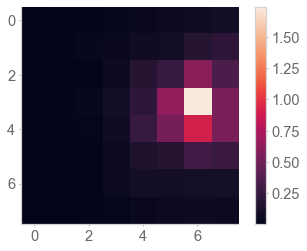

In [6]:
x = net.get_M()[30,:].reshape((8,8))
plt.imshow(x.detach().numpy())
plt.colorbar()

In [10]:
exp_dir = "../trained_models/test/"

arena_len = 8 #12
num_states = arena_len**2

# Test dataset
dset = inputs.Sim2DWalk(num_steps=200, num_states=num_states)
dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)

with open(exp_dir + 'net_configs.p', 'rb') as f:
    net_configs = pickle.load(f)
print(net_configs)

# Load that model and test
net = STDP_SR(**net_configs)
net.load_state_dict(torch.load(exp_dir + 'model.pt'))
net.set_num_states(num_states)
outs = []
for step in range(dset.num_steps):
    curr_dg_input = dg_inputs[step].unsqueeze(0)
    reset = True if step == 0 else False
    with torch.no_grad():
        _, out = net(curr_dg_input, reset=reset)
        outs.append(out)
outputs = torch.stack(outs).squeeze()

{'num_states': 2, 'gamma': 0.8, 'ca3_kwargs': {'A_pos_sign': 1, 'A_neg_sign': -1, 'output_params': {'num_iterations': 15, 'input_clamp': 100, 'nonlinearity': 'sigmoid'}}}


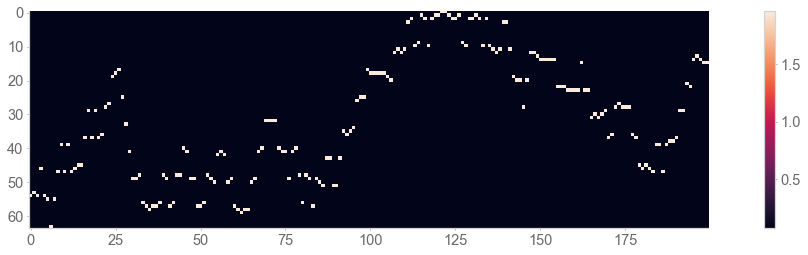

In [11]:
plt.figure(figsize=(20,4))
plt.imshow(outputs[-500:].numpy().T)
plt.colorbar()
plt.show()

In [4]:
net.ca3.downstream_scale

1

In [5]:
net.ca3.eta_inv_scale

Parameter containing:
tensor([-3.6899], requires_grad=True)

In [6]:
rnn_M = []
for i in range(num_states):
    dg_input = torch.zeros(1, 1, num_states)
    dg_input[0,0,i] = 1.
    with torch.no_grad():
        _, out = net(dg_input, reset=False, update=False)
    rnn_M.append(out.detach().numpy().squeeze())
rnn_M = np.array(rnn_M)

In [7]:
test_idx = 55

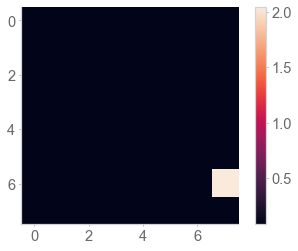

In [8]:
plt.imshow(rnn_M[test_idx].reshape((arena_len, arena_len)))
plt.colorbar()

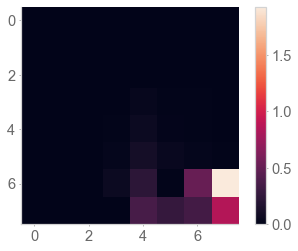

In [9]:
est_T = dset.est_T
est_M = np.linalg.pinv(
    np.eye(est_T.shape[0]) - net.gamma*est_T
    )
x = est_M[test_idx,:].reshape((arena_len,arena_len))
plt.imshow(x)
plt.colorbar()

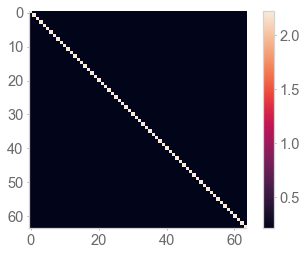

In [120]:
plt.imshow(rnn_M)
plt.colorbar()
plt.show()

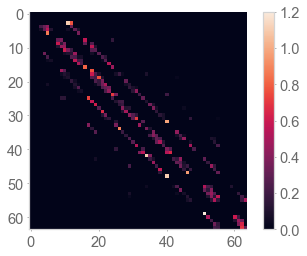

In [280]:
rnn_T = net.get_T().numpy()
plt.imshow(rnn_T)
plt.colorbar()
plt.show()

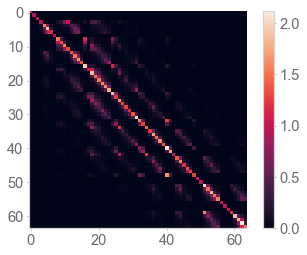

In [281]:
plt.imshow(est_M)
plt.colorbar()
plt.show()

In [12]:
np.diag(est_M).min()

1.0

In [13]:
M_off_diag = est_M.copy()
np.fill_diagonal(M_off_diag, 0)
print(M_off_diag.max())

1.6814382328275372


In [38]:
net.ca3.output_param_scale

Parameter containing:
tensor([1.5973], requires_grad=True)

In [39]:
net.ca3.output_param_bias

Parameter containing:
tensor([-0.1431], requires_grad=True)

# Firing field function (smooths with Gaussian)

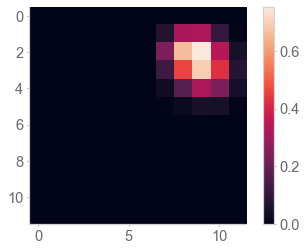

In [34]:
with torch.no_grad():
    field, nan_idxs = get_firing_field(
        dset.xs[-100:],
        dset.ys[-100:],
        outputs[-100:,test_idx], arena_len
        )
plt.imshow(field)
plt.colorbar()